## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    recall_score, precision_score, jaccard_score, accuracy_score
)

In [2]:
%load_ext watermark
%watermark --machine --python --iversions

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.12.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.24.3
pandas    : 1.4.2
matplotlib: 3.5.1



## 2. Data

In [3]:
def prep_data(df):
    cols = [
        "id", "loan_amnt", "loan_status",
        "term", "int_rate", "installment", "emp_length",
        "home_ownership", "annual_inc", "purpose", "dti",
        "delinq_2yrs", "mths_since_last_delinq",
        "open_acc", "total_acc",
        "revol_bal", "earliest_cr_line"
    ]
    df = (
        df[cols]
        .rename(columns = {
            'id': 'customer_id',
            'loan_amnt': 'loan_amount',
            'int_rate': 'interest_rate',
            'emp_length': 'employment_length',
            'annual_inc': 'annual_income',
            'delinq_2yrs': 'delinquency_2years',
            'mths_since_last_delinq': 'months_since_delinquency',
            'earliest_cr_line': 'min_date_credit_line',
            'open_acc': 'open_accounts',
            'total_acc': 'total_accounts',
            'revol_bal': 'revolving_balance'
        })
        .assign(
            months_since_delinquency = lambda df_: 
                df_.months_since_delinquency.fillna(0)
        )
        .assign(
            loan_status = lambda df_:
                df_.loan_status.replace({
                    'Charged Off': 'bad', 'Default': 'bad',
                    'Late (31-120 days)': 'bad', 'Late (16-30 days)': 'bad',
                    'In Grace Period': 'good', 'Current': 'good', 'Fully Paid': 'good'
                }).astype('category'),
            home_ownership = lambda df_: df_.home_ownership.replace({
                'MORTGAGE': 'mortgage', 'RENT': 'rent',
                'OWN': 'own', 'OTHER': 'mortgage', 'NONE': 'mortgage' 
            }).astype('category'),
            purpose = lambda df_: df_.purpose.replace({
                'debt_consolidation': 'debt_consolidation',
                'credit_card': 'credit_card',
                'home_improvement': 'home_improvement',
                'other': 'other', 'major_purchase': 'other',
                'small_business': 'other', 'car': 'other',
                'medical': 'other', 'wedding': 'other',
                'house': 'other', 'moving': 'other',
                'vacation': 'other', 'renewable_energy': 'other'
            }).astype('category')
        )
        .assign(
            employment_length = lambda df_:
                df_.employment_length.replace('< 1 year', 0.5)
                .str.extract(r'(\d+)')
                .astype('float')
                .fillna(1)
        )
        .assign(
            loan_amount = lambda df_: df_.loan_amount.astype('float'),
            term = lambda df_: df_.term.astype('category'),
            purpose = lambda df_: df_.purpose.astype('category'),
            min_date_credit_line = lambda df_: 
                pd.to_datetime(df_.min_date_credit_line)
        )
        .assign(
            min_date_credit_line = lambda df_:
                np.where(
                    df_['min_date_credit_line'] <= pd.Timestamp.today(),
                    df_.min_date_credit_line,
                    pd.to_datetime(pd.Timestamp.today())
                ).astype('datetime64[ns]')
        )
        .assign(
            min_date_credit_line = lambda df_:
                np.where(
                    df_['min_date_credit_line'] >= pd.to_datetime('1989-01-01'),
                    df_.min_date_credit_line,
                    pd.to_datetime('1989-01-01')
                ).astype('datetime64[ns]')
        )
        .assign(
            months_since_first_credit = lambda df_:
                ((pd.to_datetime('today') - df_.min_date_credit_line) / np.timedelta64(1, 'M'))
        )
        .assign(
            loan_income_ratio = lambda df_:
                df_.loan_amount / df_.annual_income,
            installment_balance_ratio = lambda df_: 
                df_.installment / (df_.revolving_balance + 1),
            open_account_ratio = lambda df_: 
                df_.open_accounts / df_.total_accounts,
            total_earnings = lambda df_: 
                df_.employment_length * df_.annual_income
        )
        .drop(columns = ['min_date_credit_line'])
        .dropna()
    )
    return df

In [4]:
df = prep_data(pd.read_csv("loan_data.csv"))

## 3. Models

In [5]:
# 3.1 Data budgeting
target = 'loan_status'
features = df.columns.drop(['customer_id', 'loan_status'])
cat_features = ['term', 'home_ownership', 'purpose']
num_features = features.drop(cat_features)

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target],
    test_size = 0.2, random_state = 1, stratify = df[target]
)

In [6]:
# 3.2 Feature pipeline
cat_transformer = make_pipeline(
    OneHotEncoder(handle_unknown = "ignore"),
    VarianceThreshold(0.0)
)

num_transformer = make_pipeline(
    VarianceThreshold(0.0),
    StandardScaler()
)

logistic_model = make_pipeline(
    ColumnTransformer([
        ('categorical', cat_transformer, cat_features),
        ('numeric', num_transformer, num_features)
    ]),
    LogisticRegression(
        penalty = "none",
        max_iter = 1000,
        class_weight = 'balanced'
    )
)

sm = SMOTENC(
    categorical_features = cat_features,
    categorical_encoder = OneHotEncoder(),
    random_state = 1, sampling_strategy = 1
)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

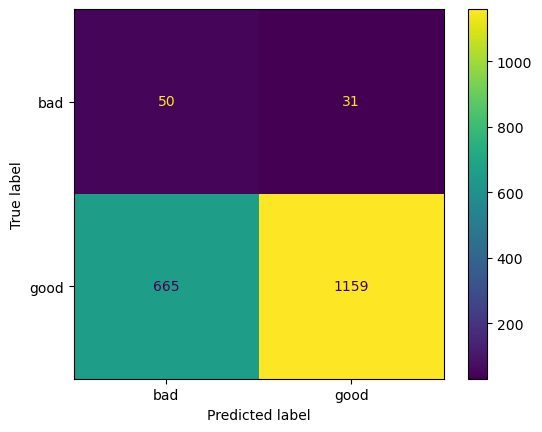

In [7]:
# 3.3 Model prediction and evaluation
logistic_model.fit(X_train_res, y_train_res)
y_pred = logistic_model.predict(X_test)
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test, y_test)
plt.show()

In [8]:
# bad = 0 (negative), good = 1 (positive)
target_names = ['bad', 'good']
print(classification_report(
    y_true = y_test.values, y_pred = y_pred, target_names = target_names
))

              precision    recall  f1-score   support

         bad       0.07      0.62      0.13        81
        good       0.97      0.64      0.77      1824

    accuracy                           0.63      1905
   macro avg       0.52      0.63      0.45      1905
weighted avg       0.94      0.63      0.74      1905



In [9]:
# 2.4 Final pickled model trained on all data
X, y = sm.fit_resample(df[features], df[target])
final_model = logistic_model.fit(X, y)
with open("final_model_saved.pickle", "wb") as file:
    pickle.dump(final_model, file)